In [1]:
import os
import sys
import pickle
import numpy as np
from math import exp
from scipy import stats
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from vizsequence.viz_sequence import plot_weights_given_ax
from scipy.special import softmax
import keras
import keras.losses
from keras.models import Model, Sequential, load_model
from keras import backend as K
import numpy.random as rng
import seaborn as sns
from collections import OrderedDict
from basepair.losses import twochannel_multinomial_nll
import modisco
import modisco.tfmodisco_workflow.workflow
from modisco.tfmodisco_workflow import workflow
import h5py
import modisco.util
from collections import Counter
from modisco.visualization import viz_sequence
import modisco.affinitymat.core
import modisco.cluster.phenograph.core
import modisco.cluster.phenograph.cluster
import modisco.cluster.core
import modisco.aggregator
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

2020-12-09 13:04:27,001 [WARNING] From /users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

TF-MoDISco is using the TensorFlow backend.


In [2]:
all_post_counts_hypimps = np.load("/users/amr1/pho4/data/imp-scores/cbf1_pbexo/post_profile_hypimps.npy")
all_post_counts_actualimps = np.load("/users/amr1/pho4/data/imp-scores/cbf1_pbexo/post_profile_actualimps.npy")  
all_seqs = np.load("/users/amr1/pho4/data/imp-scores/cbf1_pbexo/seqs.npy")

In [3]:
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=["task0"],
                contrib_scores={"task0": all_post_counts_actualimps},
                hypothetical_contribs={"task0": all_post_counts_hypimps},
                one_hot=all_seqs)

grp = h5py.File("data/modisco/cbf1_pbexo/task0_profile_results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

Untrimmed - sequence (scaled by information content)


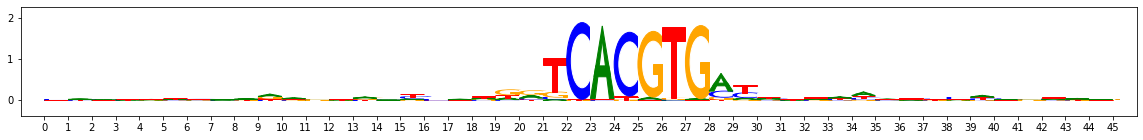

Untrimmed - task 0 hypothetical scores


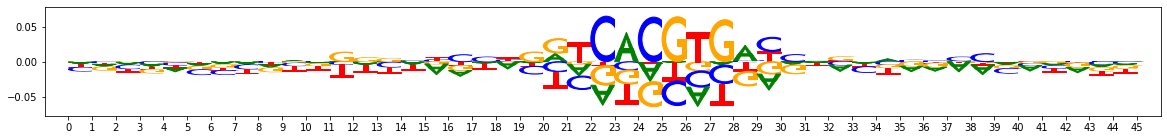

IC-trimmed - sequence (scaled by information content)


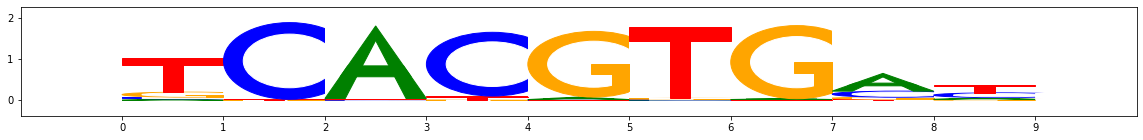

In [4]:
background = np.array([0.27, 0.23, 0.23, 0.27])
untrimmed_pattern = (
    loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_0"]
    .seqlets_to_patterns_result.patterns[0])
print("Untrimmed - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(untrimmed_pattern["sequence"].fwd, background=background))
print("Untrimmed - task 0 hypothetical scores")
viz_sequence.plot_weights(untrimmed_pattern["task0_hypothetical_contribs"].fwd)
trimmed = untrimmed_pattern.trim_by_ic(ppm_track_name="sequence", background=background, threshold=0.3)
print("IC-trimmed - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(trimmed["sequence"].fwd, background=background))

In [5]:
print(trimmed["task0_hypothetical_contribs"].fwd)

[[-0.01667978 -0.01923664 -0.00386041  0.02751783]
 [-0.02863287  0.06503343 -0.02839889 -0.00530528]
 [ 0.04186128 -0.01167789 -0.02041616 -0.02856014]
 [-0.02717614  0.06368314 -0.03586076 -0.00131618]
 [-0.00081984 -0.03512051  0.06417695 -0.02677255]
 [-0.02772136 -0.02319901 -0.01318957  0.04251578]
 [-0.00487623 -0.02632816  0.05999639 -0.03081606]
 [ 0.02199298  0.00142217 -0.0207806  -0.013872  ]
 [-0.02299521  0.02023267 -0.01771216  0.01465537]]


In [6]:
imp_scores = all_post_counts_actualimps
onehot_seq = np.array(all_seqs)
fwd_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed["task0_hypothetical_contribs"].fwd)
rev_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed["task0_hypothetical_contribs"].rev)

#We take the max of the masked_cosine_sim on the fwd and reverse strands
is_fwd_masked_cosine_sim = fwd_masked_cosine_sim > rev_masked_cosine_sim
masked_cosine_sim = (fwd_masked_cosine_sim*is_fwd_masked_cosine_sim
                     + rev_masked_cosine_sim*(is_fwd_masked_cosine_sim==False))

#Also look at the total sum of scores in each window
sum_scores = modisco.util.compute_sum_scores(imp_scores=imp_scores,
                                             window_size=len(trimmed["task0_hypothetical_contribs"].fwd))

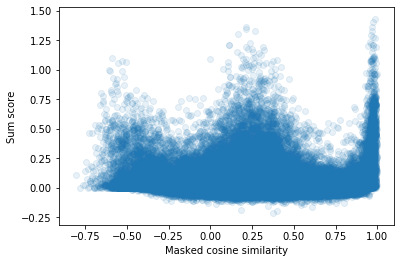

In [7]:
plt.scatter(masked_cosine_sim.ravel(), sum_scores.ravel(), alpha=0.1)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.show()

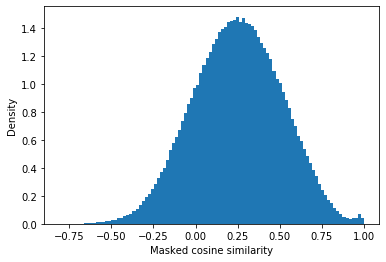

In [8]:
plt.hist(masked_cosine_sim.ravel(), bins=100, density=True)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Density")
plt.show()

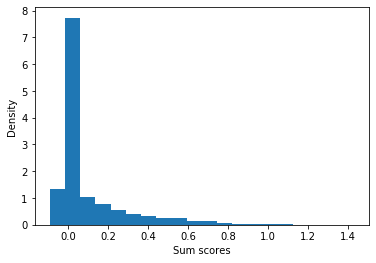

In [9]:
masked_cosine_sim_thresh = 0.8
plt.hist(sum_scores.ravel()[masked_cosine_sim.ravel() > masked_cosine_sim_thresh],
         bins=20, density=True)
plt.xlabel("Sum scores")
plt.ylabel("Density")
plt.show()

In [10]:
sum_score_thresh = 0.1
threshold_passers = ((masked_cosine_sim > masked_cosine_sim_thresh)*
                     (sum_scores > sum_score_thresh))

In [11]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
len(hit_locations)

1983

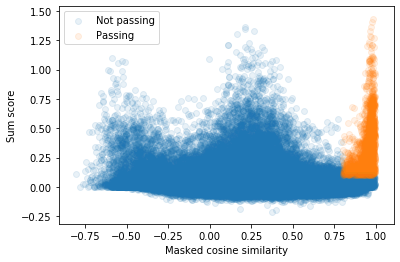

In [12]:
handles = []
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers==False].ravel(),
            sum_scores[threshold_passers==False].ravel(), alpha=0.1))
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers].ravel(),
            sum_scores[threshold_passers].ravel(), alpha=0.1))
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.legend(handles=handles, labels=["Not passing", "Passing"])
plt.show()

cosine similarity: 0.9013789669377759 sum scores: 0.2567566810539574


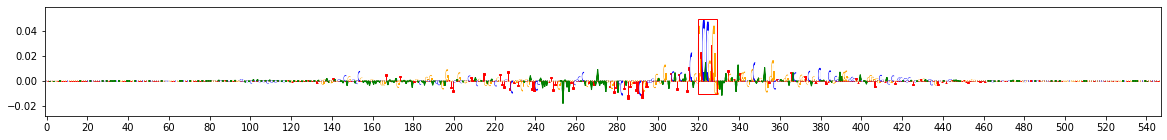

cosine similarity: 0.9458491804850243 sum scores: 0.20202157967942183


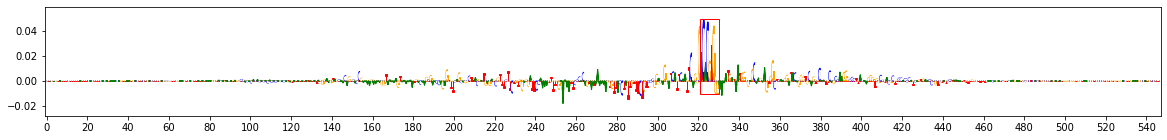

cosine similarity: 0.922627658345368 sum scores: 0.30195689218526245


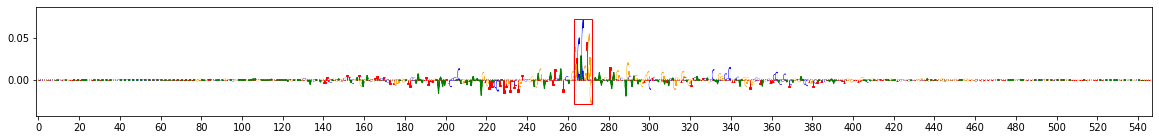

In [13]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
num_to_viz = 3
for (seq_idx, hit_pos) in hit_locations[:num_to_viz]:
    print("cosine similarity:", masked_cosine_sim[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)     
    viz_sequence.plot_weights_given_ax(ax=ax,
        array=imp_scores[seq_idx],
        height_padding_factor=0.2,
        length_padding=1.0,
        highlight={'red': [(hit_pos, hit_pos+len(trimmed))]},
        subticks_frequency=20)
    plt.show()

In [14]:
centered_imps = []
for (seq_idx, hit_pos) in hit_locations:
    centered_imps.append(imp_scores[seq_idx][hit_pos-50:hit_pos+50])
centered_imps = np.array(centered_imps)

counts imp


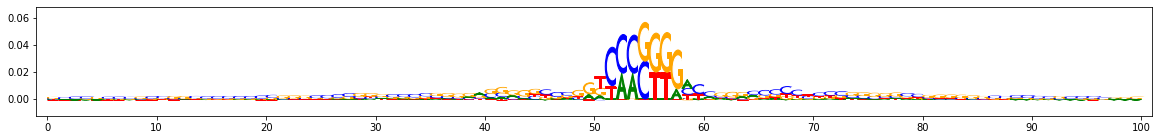

In [15]:
print("counts imp")
viz_sequence.plot_weights(np.mean(centered_imps, axis=0), subticks_frequency=10)

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


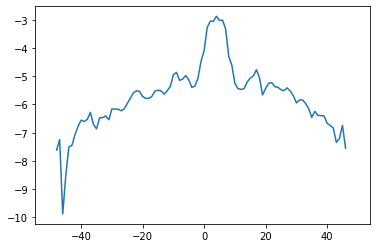

In [16]:
magnitude_imps = np.sum(centered_imps, axis=-1)
plt.plot(np.arange(-50,50,1), np.log(np.mean(magnitude_imps, axis=0)))

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


(-7, -2)

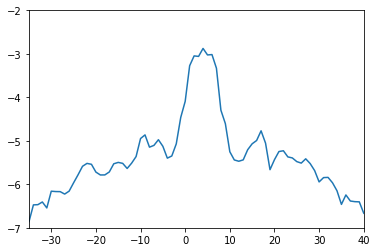

In [17]:
plt.plot(np.arange(-50,50,1), np.log(np.mean(magnitude_imps, axis=0)))
plt.xlim((-35,40))
plt.ylim((-7,-2))

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


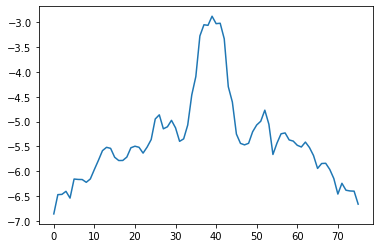

In [18]:
sig = np.log(np.mean(magnitude_imps, axis=0))[15:91]
plt.plot(sig)

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 76, using nperseg = 76
  .format(nperseg, input_length))
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide


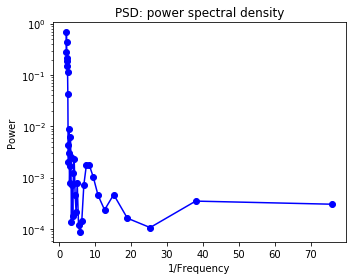

In [19]:
from scipy import signal
freqs, psd = signal.welch(sig, scaling='spectrum')

plt.figure(figsize=(5, 4))
plt.semilogy(1.0/freqs[::-1], psd, '-bo')
plt.title('PSD: power spectral density')
plt.xlabel('1/Frequency')
plt.ylabel('Power')
plt.tight_layout()

In [20]:
all_coords = np.load("/users/amr1/pho4/data/imp-scores/cbf1_pbexo/coords.npy")

In [21]:
chrmToHits = {}
for (seq_idx, hit_pos) in hit_locations:
    chrm, _, interval = all_coords[seq_idx].split(':')
    start, _ = interval.split('-')
    if chrm not in chrmToHits:
        chrmToHits[chrm] = []
    chrmToHits[chrm].append(int(start)+hit_pos)

In [22]:
motif = trimmed["sequence"].fwd

In [23]:
len(motif)

9

In [24]:
distances = []
for chrm in chrmToHits:
    for idx in range(0, len(chrmToHits[chrm])):
        pos1 = chrmToHits[chrm][idx]
        for idy in range(idx+1, len(chrmToHits[chrm])):
            pos2 = chrmToHits[chrm][idy]
            dist = abs(pos1-pos2)
            if dist <= 100:
                distances.append(dist)

In [25]:
len(distances)

10094

Text(0.5, 1.0, 'Pair distances in genome')

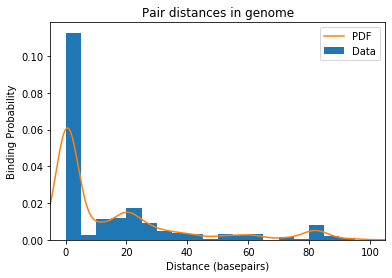

In [26]:
import scipy.stats as st

plt.hist(distances, density=True, bins=20, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 301)
kde = st.gaussian_kde(distances)
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper right")
plt.ylabel('Binding Probability')
plt.xlabel('Distance (basepairs)')
plt.title("Pair distances in genome")

Text(0.5, 1.0, 'Pair distances in genome')

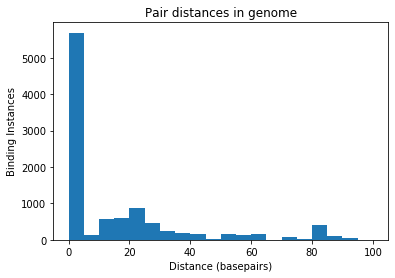

In [27]:
plt.hist(distances, density=False, bins=20, label="Data")
plt.ylabel('Binding Instances')
plt.xlabel('Distance (basepairs)')
plt.title("Pair distances in genome")

In [28]:
import pyBigWig
posbw = pyBigWig.open("data/cbf1_pbexo/basename_prefix.pooled.positive.bigwig")
negbw = pyBigWig.open("data/cbf1_pbexo/basename_prefix.pooled.negative.bigwig")

In [29]:
distToSummitVals = {}
for chrm in chrmToHits:
    for idx in range(0, len(chrmToHits[chrm])):
        summit1 = chrmToHits[chrm][idx]
        for idy in range(idx+1, len(chrmToHits[chrm])):
            summit2 = chrmToHits[chrm][idy]
            dist = abs(summit1-summit2)
            if dist > 50: continue
            if dist not in distToSummitVals:
                distToSummitVals[dist] = []
            posvals = np.array(posbw.values(chrm, summit1-2, summit1+2))
            where_are_NaNs = np.isnan(posvals)
            posvals[where_are_NaNs] = 0.0
            summitValPos = max(posvals)
            negvals = np.array(negbw.values(chrm, summit1-2, summit1+2))
            where_are_NaNs = np.isnan(negvals)
            negvals[where_are_NaNs] = 0.0
            summitValNeg = max(np.abs(negvals))
            summit1Val = max(summitValNeg, summitValPos)

            posvals = np.array(posbw.values(chrm, summit2-2, summit2+2))
            where_are_NaNs = np.isnan(posvals)
            posvals[where_are_NaNs] = 0.0
            summitValPos = max(posvals)
            negvals = np.array(negbw.values(chrm, summit2-2, summit2+2))
            where_are_NaNs = np.isnan(negvals)
            negvals[where_are_NaNs] = 0.0
            summitValNeg = max(np.abs(negvals))
            summit2Val = max(summitValNeg, summitValPos)

            distToSummitVals[dist].append((summit1Val+summit2Val)/2.0)

In [30]:
origX = []
for dist in distToSummitVals:
    origX.append(dist)
origX.sort()

In [31]:
bucket = 1
xvals = []
summitVals = {}
for idx in range(0, len(origX)-bucket, bucket):
    xvals.append(origX[idx])
    summitVals[origX[idx]] = distToSummitVals[origX[idx]]
    for idy in range(1, bucket):
        summitVals[origX[idx]] += distToSummitVals[origX[idx]+idy]

Text(0.5, 1.0, 'summit counts in genome')

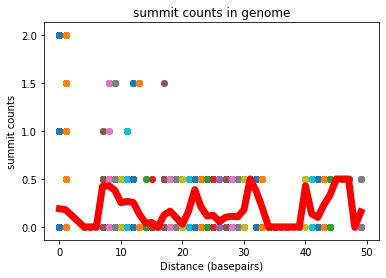

In [32]:
yvals = []
for dist in xvals:
    yvals.append(np.mean(summitVals[dist]))
for dist in xvals:
    plt.scatter([dist] * len(distToSummitVals[dist]), distToSummitVals[dist])
plt.plot(xvals, yvals, color='red', linewidth=7.0)
plt.ylabel('summit counts')
plt.xlabel('Distance (basepairs)')
plt.title("summit counts in genome")